# Семантическая Сегментация. Часть 3.

## Переключение версии TensorFlow

In [25]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Загрузка датасета COCO и COCO API

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Подготовка COCO API

In [5]:
os.sys.path.append('cocoapi/PythonAPI/pycocotools')

In [6]:
from pycocotools.coco import COCO

In [7]:
COCO_ROOT = '/content/drive/MyDrive/Colab Notebooks/CV'


## Универсальный класс Dataset для сегментации

In [31]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]


        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return tf.reshape(img,[224,224,3]), tf.reshape(mask_class,[224,224,1])
       

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        # dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return tf.reshape(img,[224,224,3]), tf.reshape(mask_class,[224,224,1])

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [13]:

true_train_id=[int(i[:12]) for i in list(os.walk('/content/drive/MyDrive/Colab Notebooks/CV/train2017/'))[0][2]]


In [14]:
true_val_id=[int(i[:12]) for i in list(os.walk('/content/drive/MyDrive/Colab Notebooks/CV/val2017/'))[0][2]]

In [28]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        if sublist=='train':
          self.img_list =[i for i in self.coco.getImgIds(catIds=self.cat_ids) if i in true_train_id]
        else:
          self.img_list =[i for i in self.coco.getImgIds(catIds=self.cat_ids) if i in true_val_id]
    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        # print(img_id)
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [33]:

COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=25.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [34]:
train_ds = COCO_dataset_train.train_dataset(32,epochs=10,inp_size= 224)
val_ds = COCO_dataset_val.val_dataset(32,inp_size=224)

11 (224, 224, None)
33 (224, 224, None)
22 (224, 224, None) Tensor("Cast_1:0", shape=(224, 224, None), dtype=float32)
11 (None, None, None)


In [70]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((224, 224, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [20]:
def scheduler(epoch, lr):
    if epoch <3 :
        return lr
    else:
        return lr * 0.9

In [36]:
ch_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
es_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=2, verbose=0,restore_best_weights=True
)

Epoch 1/10
29/29 [==============================] - 213s 7s/step - loss: 0.5186 - accuracy: 0.7733 - val_loss: 0.5815 - val_accuracy: 0.7309
Epoch 2/10
29/29 [==============================] - 158s 6s/step - loss: 0.4955 - accuracy: 0.7779 - val_loss: 0.5393 - val_accuracy: 0.7309
Epoch 3/10
29/29 [==============================] - 212s 7s/step - loss: 0.4849 - accuracy: 0.7729 - val_loss: 0.5482 - val_accuracy: 0.7310
Epoch 4/10
29/29 [==============================] - 156s 5s/step - loss: 0.4890 - accuracy: 0.7754 - val_loss: 0.5296 - val_accuracy: 0.7410
Epoch 5/10
29/29 [==============================] - 213s 8s/step - loss: 0.4904 - accuracy: 0.7790 - val_loss: 0.5424 - val_accuracy: 0.7335
Epoch 6/10
29/29 [==============================] - 214s 8s/step - loss: 0.4811 - accuracy: 0.7778 - val_loss: 0.5324 - val_accuracy: 0.7498
Epoch 7/10
29/29 [==============================] - 157s 6s/step - loss: 0.4835 - accuracy: 0.7830 - val_loss: 0.5223 - val_accuracy: 0.7502
Epoch 8/10
29

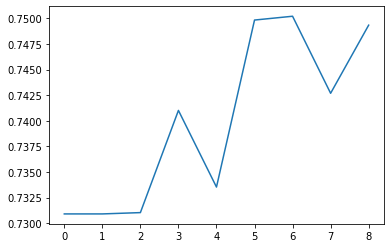

In [39]:
NUM_EPOCHS = 10
# BATCH_SIZE = 1
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)


loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss,metrics=['accuracy'])

hist = model.fit(train_ds,validation_data=val_ds,epochs=NUM_EPOCHS,callbacks=[es_callback,lr_callback,ch_callback ])

plt.plot(hist.history['val_accuracy'])

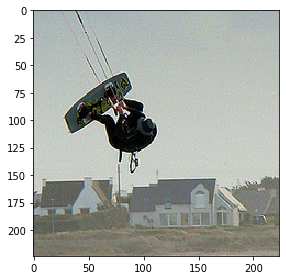

In [60]:
test_img=list(val_ds.take(1))[0][0][0].numpy()
io.imshow(test_img)

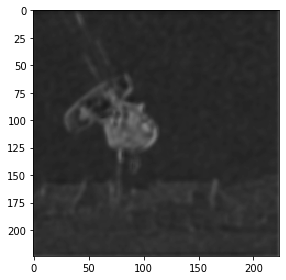

In [66]:
io.imshow(model.predict(test_img.reshape(1,*test_img.shape))[0][:,:,0])